In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from pathlib import Path
sns.set_style('whitegrid')

In [4]:
comp_dir = Path('store-sales-time-series-forecasting')

In [5]:

holidays_events = pd.read_csv(
    comp_dir / "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date']
)
holidays_events = holidays_events.set_index('date').to_period('D')

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

<Axes: xlabel='day', ylabel='sales'>

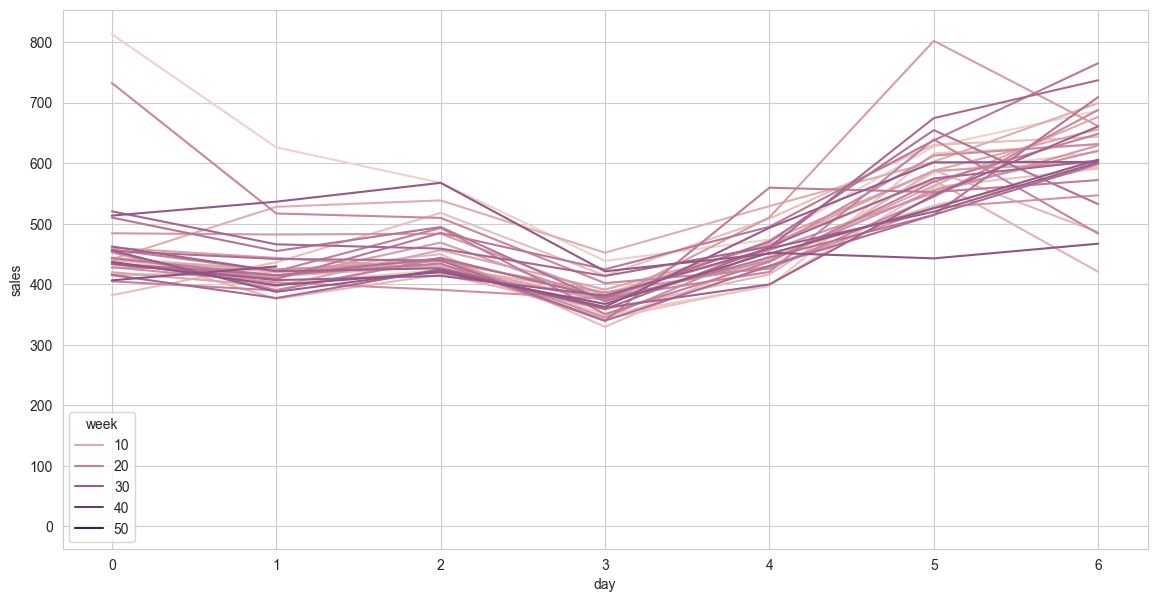

In [6]:
X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
plt.figure(figsize=(14, 7))
sns.lineplot(data=X, x='day', y='sales', hue='week')

In [7]:
y = average_sales.copy()

fourier = CalendarFourier(freq='ME', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()

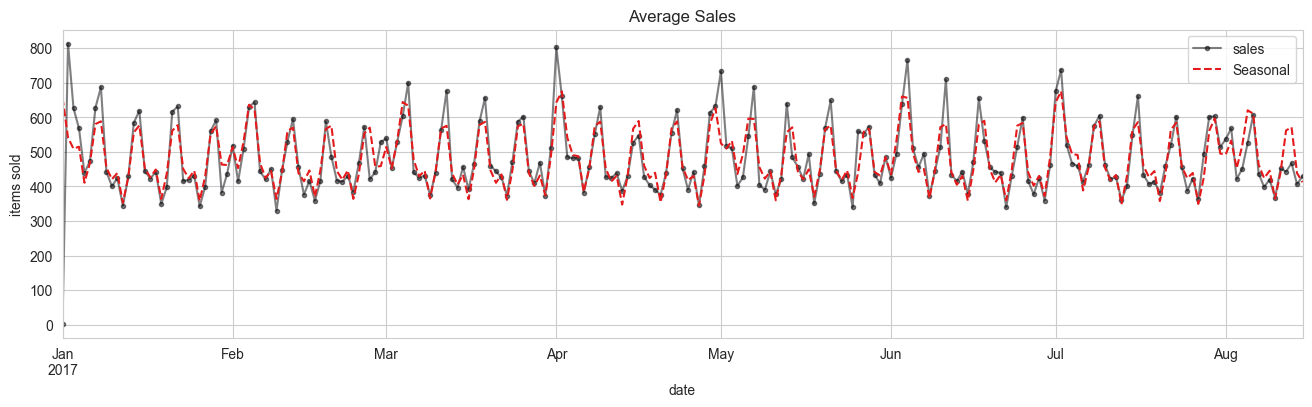

In [14]:
model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X), index=X.index)
plt.figure(figsize=(16, 4))
ax = y.plot(marker='.',cmap='magma', alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(linestyle='--',cmap='Set1',ax=ax, label="Seasonal")
ax.legend();

In [15]:
# National and regional holidays in train data
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

display(holidays)

,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi
2017-04-14,Viernes Santo
2017-05-01,Dia del Trabajo
2017-05-13,Dia de la Madre-1
2017-05-14,Dia de la Madre
